# Support for dask arrays

It is possible to operate on dask arrays and spare the memory (or perhaps even time).

In [1]:
# Necessary imports
import numpy as np

import dask
import dask.array as da
from physt import h1, h2

In [2]:
# Create two arrays
np.random.seed(42)

SIZE = 2 ** 21
CHUNK = int(SIZE / 16)

million = np.random.rand(SIZE)#.astype(int)
million2 = (3 * million + np.random.normal(0., 0.3, SIZE))#.astype(int)

# Chunk them for dask
chunked = da.from_array(million, chunks=(CHUNK))
chunked2 = da.from_array(million2, chunks=(CHUNK))

## Create histograms

`h1`, `h2`, ... have their alternatives in `physt.dask_compat`. They should work similarly. Although, they are not complete and unexpected errors may occur.

In [3]:
from physt.compat.dask import h1 as d1
from physt.compat.dask import h2 as d2

Check:  True


Histogram1D(bins=(28,), total=2097152, dtype=int32)

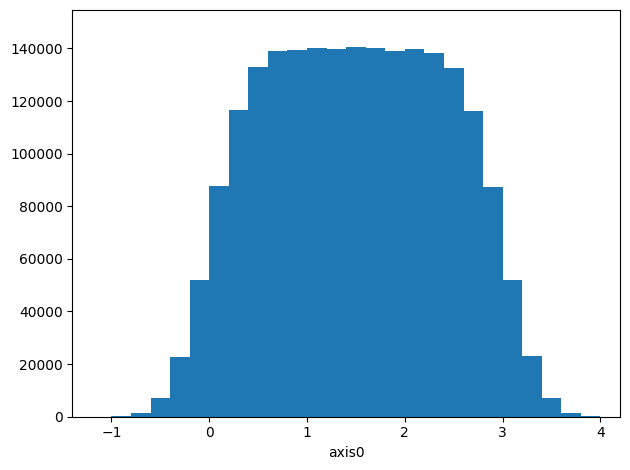

In [4]:
# Use chunks to create a 1D histogram
ha = d1(chunked2, "fixed_width", bin_width=0.2)
check_ha = h1(million2, "fixed_width", bin_width=0.2)
ok = (ha == check_ha)
print("Check: ", ok)
ha.plot()
ha

C:\Users\janpi\Documents\code\physt\src\physt\_util.py:81: FutureWarning:

histogramdd is deprecated, use h instead



Check:  True


Histogram2D(bins=(5, 28), total=2097152, dtype=int64)

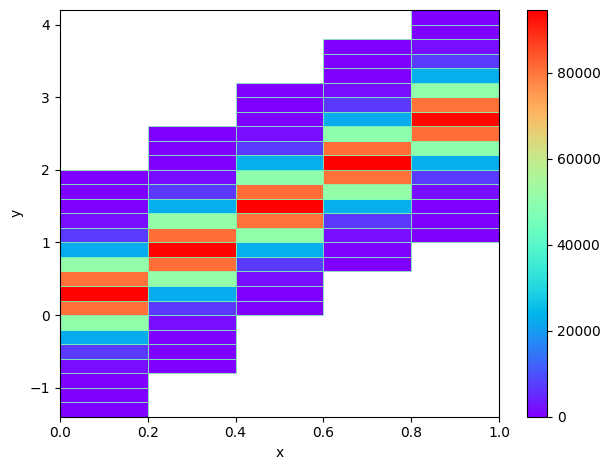

In [5]:
# Use chunks to create a 2D histogram
hb = d2(chunked, chunked2, "fixed_width", bin_width=.2, axis_names=["x", "y"])
check_hb = h2(million, million2, "fixed_width", bin_width=.2, axis_names=["x", "y"])
hb.plot(show_zero=False, cmap="rainbow")
ok = (hb == check_hb)
print("Check: ", ok)
hb

Check:  True


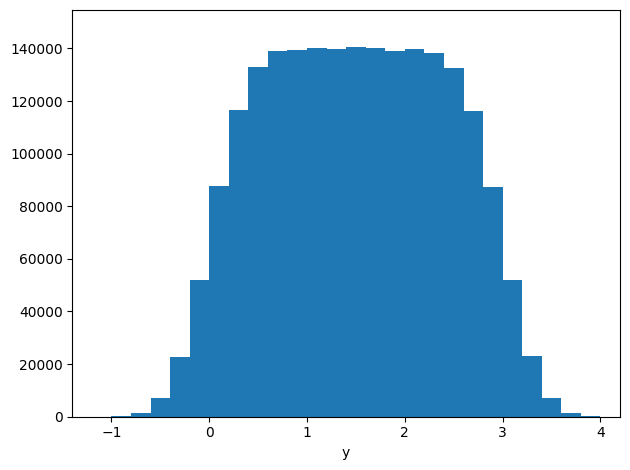

In [6]:
# And another cross-check
hh = hb.projection("y")
hh.plot()
print("Check: ", np.array_equal(hh.frequencies, ha.frequencies))   # Just frequencies

In [7]:
# Use dask for normal arrays (will automatically split array to chunks)
d1(million2, "fixed_width", bin_width=0.2) == ha

True

## Some timings

Your results may vary substantially. These numbers are just for illustration, on 4-core (8-thread) machine. The real gain comes when we have data that don't fit into memory.

### Efficiency

In [8]:
# Standard
%time h1(million2, "fixed_width", bin_width=0.2)

CPU times: total: 422 ms
Wall time: 424 ms


Histogram1D(bins=(28,), total=2097152, dtype=int32)

In [9]:
# Same array, but using dask
%time d1(million2, "fixed_width", bin_width=0.2)

CPU times: total: 484 ms
Wall time: 163 ms


Histogram1D(bins=(28,), total=2097152, dtype=int32)

In [10]:
# Most efficient: dask with already chunked data
%time d1(chunked2, "fixed_width", bin_width=0.2)

CPU times: total: 469 ms
Wall time: 149 ms


Histogram1D(bins=(28,), total=2097152, dtype=int32)

### Different scheduling

In [11]:
%time d1(chunked2, "fixed_width", bin_width=0.2)

CPU times: total: 406 ms
Wall time: 149 ms


Histogram1D(bins=(28,), total=2097152, dtype=int32)

In [12]:
%%time
# Hyper-threading or not?
graph, name = d1(chunked2, "fixed_width", bin_width=0.2, compute=False)
dask.threaded.get(graph, name, num_workers=4)

CPU times: total: 438 ms
Wall time: 157 ms


Histogram1D(bins=(28,), total=2097152, dtype=int32)

In [13]:
# Multiprocessing not so efficient for small arrays?
%time d1(chunked2, "fixed_width", bin_width=0.2, dask_method=dask.multiprocessing.get)

CPU times: total: 93.8 ms
Wall time: 2.21 s


Histogram1D(bins=(28,), total=2097152, dtype=int32)